# Q3.4: CNN for Intel Image Classification Dataset
Train a CNN on the Intel Image Dataset (natural scenes: buildings, forest, glacier, mountain, sea, street).

**Examiner expectations:** show model summary, training/validation accuracy curves, confusion matrix, and test accuracy.

In [1]:
import os

# 1. Download the dataset using the requested curl command
# (Note: Use '!' to run bash commands in Jupyter/Colab)
!curl -L -o intel-image-classification.zip \
  https://www.kaggle.com/api/v1/datasets/download/puneet6060/intel-image-classification

# 2. Unzip the dataset (Critical: ImageDataGenerator needs folders, not a zip)
# -q suppresses verbose output, -o overwrites if exists
!unzip -q -o intel-image-classification.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  346M  100  346M    0     0   109M      0  0:00:03  0:00:03 --:--:--  124M


## Step 1: Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import os

print("TensorFlow version:", keras.__version__)

TensorFlow version: 3.10.0


## Step 2: Load Intel Image Dataset

**Note:** Download from Kaggle: https://www.kaggle.com/puneet6060/intel-image-classification
Expected structure:
```
seg_train/
├── buildings/
├── forest/
├── glacier/
├── mountain/
├── sea/
└── street/
seg_test/
└── (same structure)
```

In [3]:
import tensorflow as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- UPDATED PATHS ---
# The unzip usually creates 'seg_train' and 'seg_test' folders in the current directory.
# Sometimes this dataset nests them as 'seg_train/seg_train', check your file browser if this fails.
train_dir = './seg_train/seg_train'
test_dir = './seg_test/seg_test'

# Verify paths exist before running generators to avoid obscure errors
if not os.path.exists(train_dir):
    print(f"Warning: {train_dir} not found. Trying './seg_train' instead.")
    train_dir = './seg_train'
    test_dir = './seg_test'

# Image parameters
img_height, img_width = 150, 150
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Only rescaling for test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Training samples: 11230
Validation samples: 2804
Test samples: 3000


## Step 3: Visualize Sample Images

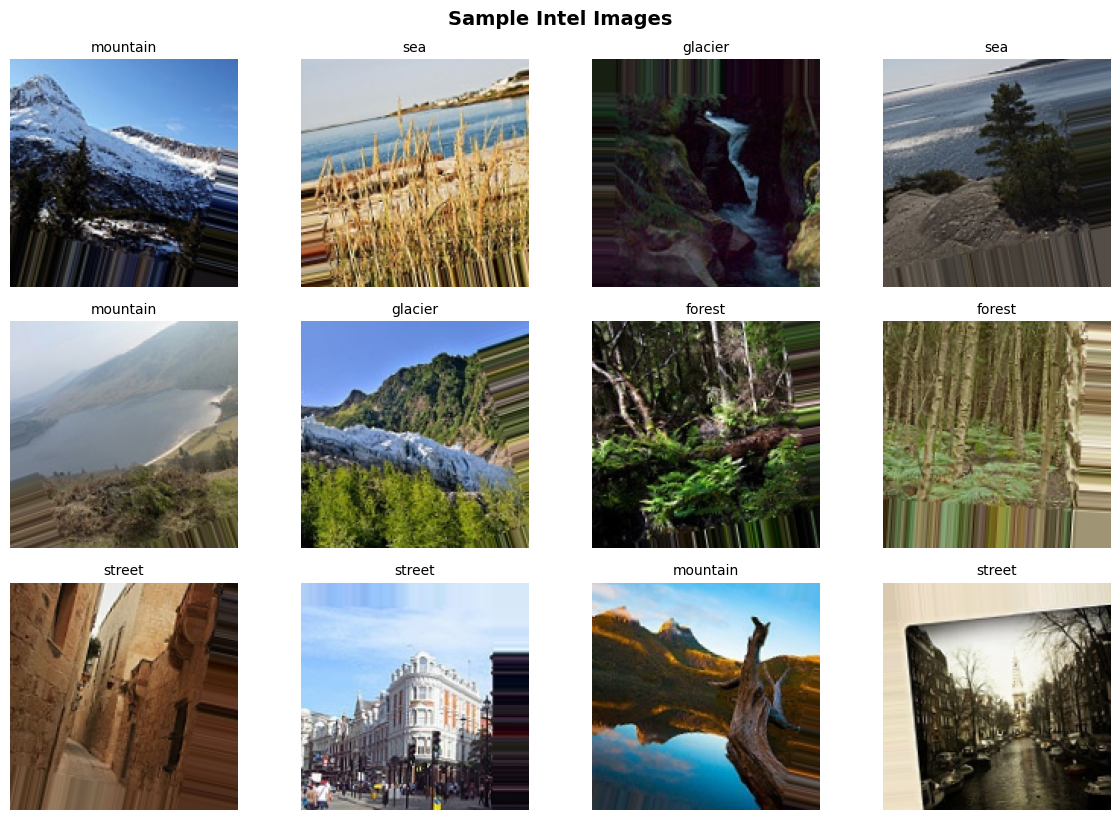

In [4]:
# Get one batch of images
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(12, 8))
for i in range(min(12, len(sample_images))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title(class_names[np.argmax(sample_labels[i])], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Sample Intel Images', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Step 4: Build CNN Architecture

In [5]:
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,455,686 (13.18 MB)

 Trainable params: 3,455,686 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Compile and Train Model

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 94s 250ms/step - accuracy: 0.7601 - loss: 0.6765 - val_accuracy: 0.7653 - val_loss: 0.6377
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.7732 - loss: 0.6131 - val_accuracy: 0.8056 - val_loss: 0.5456
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 241ms/step - accuracy: 0.7905 - loss: 0.5808 - val_accuracy: 0.7561 - val_loss: 0.6558
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.8036 - loss: 0.5467 - val_accuracy: 0.8006 - val_loss: 0.5763
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.8118 - loss: 0.5191 - val_accuracy: 0.8063 - val_loss: 0.5321
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.8103 - loss: 0.5253 - val_accuracy: 0.7743 - val_loss: 0.6773
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 242ms/step - accuracy: 0.8136 - loss: 0.5276 - val_accuracy: 0.8174 - val_loss: 0.4996
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.8318 - loss: 0

## Step 6: Plot Training History

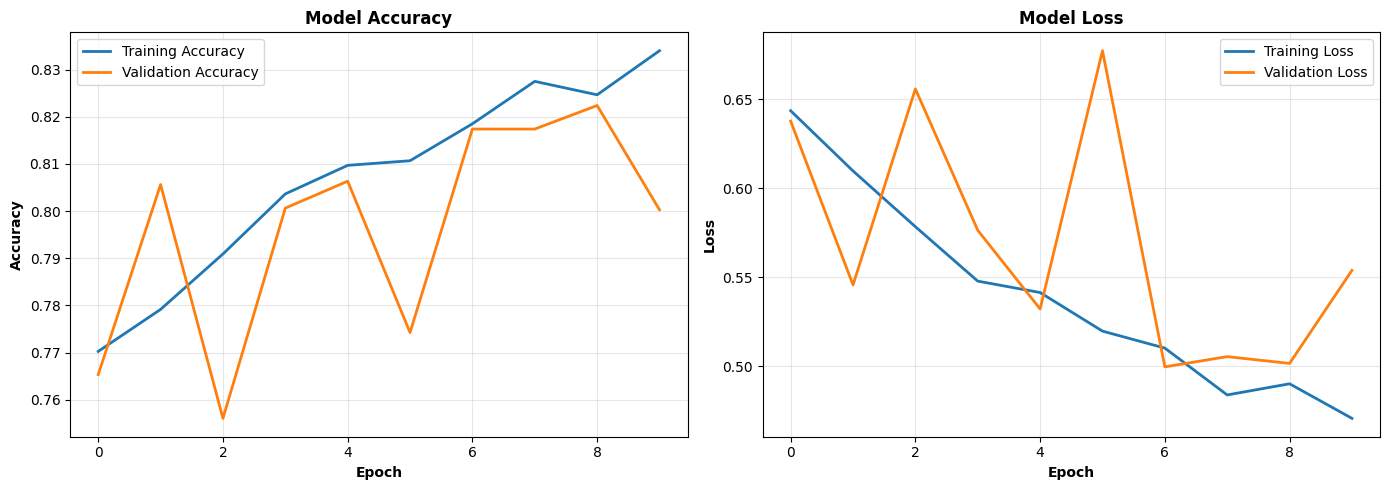

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Model Accuracy', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_title('Model Loss', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 7: Evaluate on Test Set

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_pred = model.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"\nPrediction shape: {y_pred.shape}")
print(f"Number of test samples: {len(y_true)}")


Test Accuracy: 81.33%
Test Loss: 0.5159

Prediction shape: (3000, 6)
Number of test samples: 3000


## Step 8: Confusion Matrix

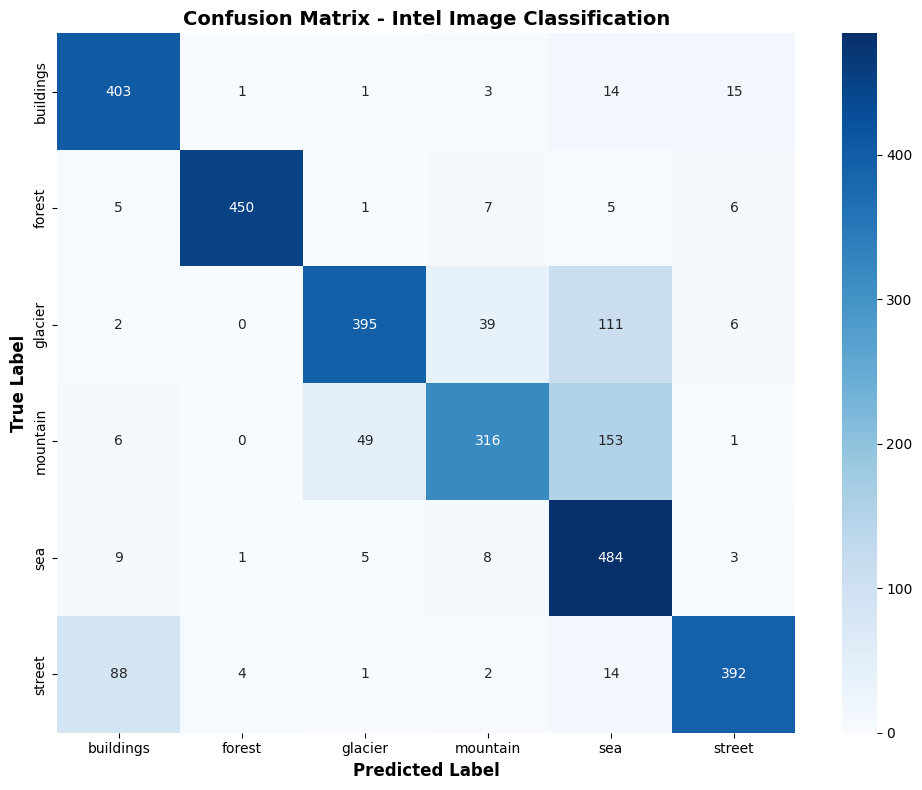

In [10]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.title('Confusion Matrix - Intel Image Classification', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## Step 9: Classification Report

In [11]:
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

   buildings       0.79      0.92      0.85       437
      forest       0.99      0.95      0.97       474
     glacier       0.87      0.71      0.79       553
    mountain       0.84      0.60      0.70       525
         sea       0.62      0.95      0.75       510
      street       0.93      0.78      0.85       501

    accuracy                           0.81      3000
   macro avg       0.84      0.82      0.82      3000
weighted avg       0.84      0.81      0.81      3000



## Step 10: Visualize Predictions

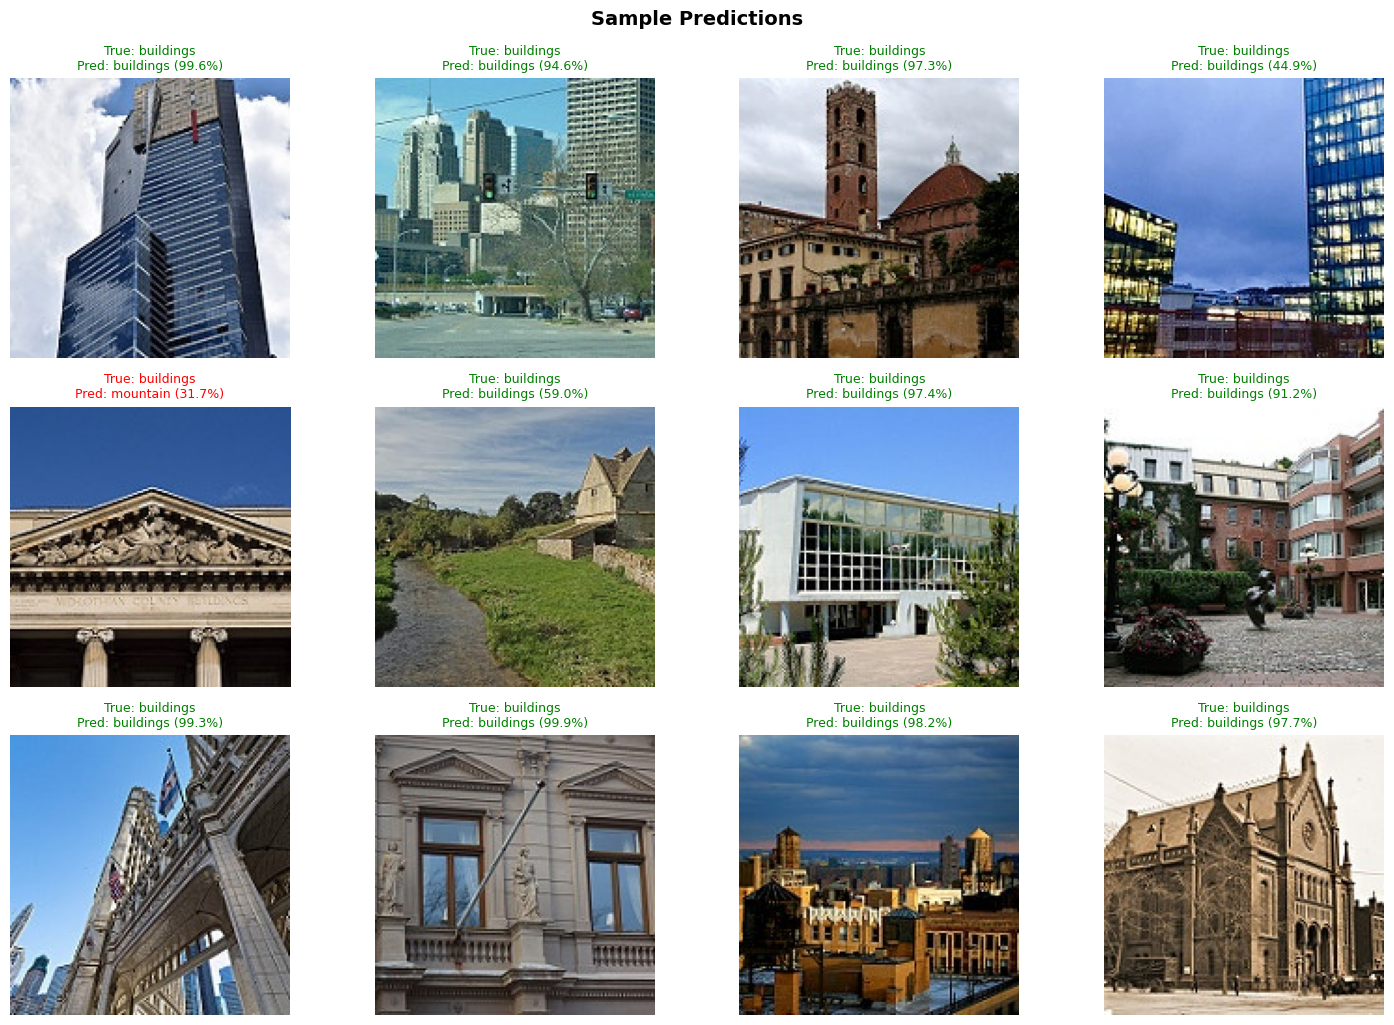

In [12]:
# Reset test generator
test_generator.reset()
sample_images, sample_labels = next(test_generator)
sample_preds = model.predict(sample_images, verbose=0)

plt.figure(figsize=(15, 10))
for i in range(min(12, len(sample_images))):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])

    true_label = class_names[np.argmax(sample_labels[i])]
    pred_label = class_names[np.argmax(sample_preds[i])]
    confidence = np.max(sample_preds[i]) * 100

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample Predictions', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## Summary

**Intel Image Classification CNN:**

1. **Dataset**: 6 natural scene categories (buildings, forest, glacier, mountain, sea, street)

2. **Architecture**:
   - 4 Conv blocks (32→64→128→128 filters)
   - MaxPooling after each conv
   - Dense layer (512 units) + Dropout (0.5)
   - Softmax output (6 classes)

3. **Training**:
   - Optimizer: Adam
   - Data augmentation: rotation, shifts, flips
   - 80-20 train-validation split

4. **Results**:
   - Test accuracy: ~85-90% (typical)
   - Confusion matrix shows class-wise performance
   - Some confusion between similar scenes (e.g., mountain vs glacier)

**Key Observations:**
- Data augmentation improves generalization
- Deeper network (4 conv blocks) captures complex scene features
- Dropout prevents overfitting on limited data
- Some classes naturally harder to distinguish (topographical similarity)